# Checking the assumptions and transformation of data

## 1. The assumptions

The ANOVA and regression methods are based on the assumptions of independence of errors, normality, homogeneity of variance and additivity. Violation of these assumptions affects the sensitivity of the F-tests in the analysis of variance. Significance tests of mean comparisons are also affected and the level of significance may be much different from what is assumed. This can result in invalid conclusions. With a computer, it is straightforward to check these assumptions so it is mandatory to check them and take the necessary action if they are seriously violated.

For each of the designs discussed so far, we have assumed an underlying model in which each observed yield is made up of various effects and a random error. These errors are assumed to be independent, normally distributed with a mean of zero, and not related to any particular treatment or block. In regression models, the magnitude of the error is independent of the X value.

The value predicted by the model is called the fitted value and the yield minus the fitted value is called the residual. The assumptions can be checked by analyzing the residuals and their relationship to the fitted values. If the assumptions are seriously violated, one solution may be to transform the data and repeat the analysis. Another solution may be to carry out a non-parametric test. An alternative to making a transformation when the errors do not follow a normal distribution is to use a **generalised linear model**.

### 1.1 Independance of errors

This is usually achieved by adequate randomisation and it is assumed that the error (residual) of an observation is not related to that of another. The yields from adjacent plots receiving the same treatment are likely to be more similar than the yields from plot far apart receiving the same treatment. You should check the experimental layout to ensure that a particular pair of treatments does not always occur in adjacent plots. If necessary you should carry out a fresh randomisation provided that the treatments have not been applied. You should not have all the plots with a given treatment next to each other. A graph of the residuals in plot order may indicate a lack of independence if there is a run of positive residuals followed by a run of negative ones.

### 1.2 Normality

The assumption of normality can be checked with a histogram of residuals, or with a normal plot (also called a Q-Q plot) of the residuals which should be a straight line. Sometimes it is not possible to tell if residuals are normally distributed if the amount of data is small. Fortunately, moderate departures of normality are not serious because the F-tests and t-tests are **robuts**, they are approximately valid when the data are not normal.

To avoid serious departures from normality when sampling from plots you should use sample means based on serval within-plot measurements. For instance,  in an experiment to compare the effects of treatments on plant yield, you may have five plots per treatment. If you just measure one plant from each plot you will have five replications per treatment, but the yields within each treatment may not be normally distributed. If you sample 10 plants from each plot, you should use the five sample means as the five replications per treatment. These means are likely to be almost exactly normally distributed. Do not use the 50 individual yields as 50 replicates per treatment.

There are situations where the measurements are markedly non-normal. Examples are counts of insects on a plant, counts of weeds in a pot, number of seeds germinating, scores on a scale of 1 to 5. In addition, this type of data usually violates other assumptions.

### 1.3 Homogeneity of variance

One assumption of the independent samples t-test is that the two sets of data come from populations with the same variance. If this assumption is justified, the two sample variances can be pooled and the test completed.

When we discussed the completely randomised design and one-way ANOVA, we pooled the variance within each treatment to get a pooled residual means square. This was used to calculated a standard error of the differences in order to compare treatment means. It was also used to calculate a pooled standard error of a treatment mean which in turn could be used to calculate confidence intervals for population means.

This pooling is only valid if the within-treatment variation is similar for each treatment, and does not depend markedly on the treatment applied. In most experiments where the differences in treatment effects are small, homogeneity of variance can be assumed and the usual analysis is valid. However, if you propose to carry out an analysis of variance on counts, you should check the assumption of homogeneity of variance. If this assumption is violated a transformation is called for. Alternatively you could use a generalised linear model.

In experiments where the treatment means are very different, the variation within treatments with large means is often much larger than the variation within treatments with small means. Failure to check the assumptions in these cases can lead to serious errors of interpretation of results. Let's illustrate this problem with an example.

Three different herbicides (A, B, C) were compared using a completely randomised design with six plots per herbicide. Included in the design were six untreated plots (D). The number of weeds per plot were counted. We will refer as A, B, C and D as treatments.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.stats import t
from scipy.stats import probplot

In [2]:
#number of weeds for each treatment
weeds = pd.DataFrame({'A':[4, 5, 2, 5, 4, 1],
                      'B':[8, 11, 9, 12, 7, 7],
                      'C':[25, 28, 20, 15, 14, 30],
                      'D':[33, 21, 48, 18, 53, 31]})

#show mean and variance
#variances are very different between samples
print(pd.concat([weeds.mean(), weeds.var()], axis=1).rename(columns={0:'mean', 1:'variance'}))

   mean  variance
A   3.5       2.7
B   9.0       4.4
C  22.0      45.2
D  34.0     198.4


There is a very large difference between variances. If we proceed with ANOVA, the pooled variance estimate is the average of the separate variances because of equal replication.

In [9]:
def anova(data, xlabel, ylabel, lsd=False):
    """Perform ANOVA on a pandas DataFrame where treatments are present in colums and repetitions in rows. The argument lsd
    can be set to True to calculate the Least Significant Difference."""
    
    #calculate descriptive parameters
    means = data.mean()
    variances = data.var()
    std_err = np.sqrt(variances / data.count())
    std_dev = np.sqrt(variances)
    Sxx = (data ** 2).sum() - data.sum() ** 2 / data.count()
    
    #=====================#
    #=== plot the data ===#
    #=====================#
    
    pos = list(range(len(data)))
    fig, ax = plt.subplots()
    for i, col in enumerate(data.columns):
        ax.bar(pos[i], np.mean(data[col]), zorder=3, edgecolor='k', linewidth=.5)
        ax.errorbar(pos[i], np.mean(data[col]), std_dev[i], zorder=4, c='k', capsize=5)
        
    #optimize figure style
    ax.set_xticks(pos)
    ax.tick_params(axis='both', color='white')
    ax.set_xticklabels(data.columns)
    for position in ['top', 'right', 'bottom', 'left']:
        ax.spines[position].set_visible(False)
        
    #add grid
    ax.grid(axis='y', color='lightgrey')
    
    #add axes label
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    plt.show()
    
    #=============#
    #=== ANOVA ===#
    #=============#
    
    #calculate N (total number of values) and t (number of treatments)
    N = len(data.values.flatten())
    nb_t = len(data.columns)

    #calculate total sum of squares
    total_ss = data.values.flatten().var(ddof=1) * (data.size - 1)

    #calculate treatment sum of squares
    treat_ss = sum(data.sum() ** 2 / data.count()) - (data.values.sum()) ** 2 / N

    #calculate residual sum of squares
    resid_ss = total_ss - treat_ss
    
    #calculate the experimental error variance
    resid_ms = Sxx.sum() / (N - nb_t)
    
    #calculate treatment mean square
    treat_ms = treat_ss / (nb_t - 1)

    #calculate vr
    vr = treat_ms / resid_ms

    #calculate p-value
    p_val = 1 - f.cdf(vr, nb_t - 1, N - nb_t)
    
    #calculate coefficient of variation
    gm = data.values.sum() / len(data.values.flatten()) #grand mean
    cv = np.sqrt(resid_ms) / gm * 100
    
    #=====================#
    #=== print results ===#
    #=====================#
    
    print('Analysis of variance')
    print('{0:10}{1:>10}{2:>10}{3:>10}{4:>10}{5:>10}'.format('Source', 'df', 'Sum sq', 'Mean sq', 'F-value', 'p-value'))
    print('{0:10}{1:>10}{2:>10.2f}{3:>10.2f}{4:>10.3f}{5:>10.5f}'.format('Treatments', nb_t - 1, treat_ss, treat_ms, vr, 
                                                                         p_val))
    print('{0:10}{1:>10}{2:>10.2f}{3:>10.2f}'.format('Residuals', N - nb_t, resid_ss, resid_ms))
    print('{0:10}{1:>10}{2:>10.2f}'.format('Total', N - 1, total_ss))
    print()
    print('{0:5}{1:>10}{2:>10}{3:>10}'.format('Level', 'N', 'Mean', 'StDev'))
    for i in range(nb_t):
        print('{0:5}{1:>10}{2:>10.3f}{3:>10.3f}'.format(data.columns[i], data.count().iloc[i], means[i], std_dev[i]))
    print()
    print('Coefficient of variation : {:.2f}%'.format(cv))
    print()
    
    if lsd:
        #calculate sum of squares
        Sxx = (data ** 2).sum() - data.sum() ** 2 / data.count()
    
        #calculate N (total number of values) and nb_t (number of treatments)
        N = len(data.values.flatten())
        nb_t = len(data.columns)

        #calculate the experimental error variance
        resid_ms = Sxx.sum() / (N - nb_t)

        #calculate standard error of the difference
        #assume same number of replications between treatments
        sed = np.sqrt(2 * resid_ms / len(data[data.columns[0]]))

        #calculate least significant difference
        lsd = t.ppf(0.975, df=N - nb_t) * sed
        
        print('LSD : {:.3f}'.format(lsd))

    #===========================#
    #=== assumption checking ===#
    #===========================#

    #residual dataframe
    #residuals = ((data - data.mean()).T - data.mean(axis=1)).T + data.values.flatten().mean()
    residuals = data - data.mean()

    #fitted dataframe
    fitted = data - residuals

    #checking normality of residuals with plot
    fig, axes = plt.subplots(nrows=2, ncols=2)
    ax0, ax1, ax2, ax3 = axes.flatten()
    qq_resid = probplot(residuals.values.flatten(), plot=ax0)
    ax0.get_lines()[0].set_markerfacecolor('C0')
    ax0.get_lines()[0].set_markeredgewidth(0)
    ax0.get_lines()[1].set_color('C3')
    ax0.set_title('Normal plot of residuals')

    ax1.axhline(0, color='grey', lw=1, linestyle='dashed')
    ax1.plot(list(range(N)), residuals.values.T.flatten())
    ax1.set_xlabel('Observation number')
    ax1.set_ylabel('Residual')
    ax1.set_title('Chart of residuals')

    ax2.hist(residuals.values.flatten())
    ax2.set_xlabel('Residual')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Histogram of residuals')

    ax3.axhline(0, color='grey', lw=1, linestyle='dashed')
    ax3.scatter(fitted.values.flatten(), residuals.values.flatten())
    ax3.set_xlabel('Fit')
    ax3.set_ylabel('Residual')
    ax3.set_title('Residuals versus fits')

    plt.subplots_adjust(hspace=0.8, wspace=0.4)

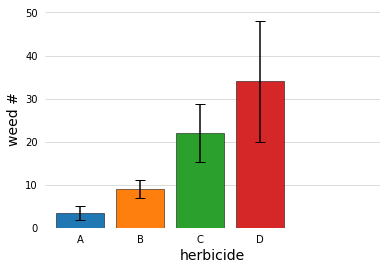

Analysis of variance
Source            df    Sum sq   Mean sq   F-value   p-value
Treatments         3   3361.12   1120.38    17.876   0.00001
Residuals         20   1253.50     62.67
Total             23   4614.62

Level         N      Mean     StDev
A             6     3.500     1.643
B             6     9.000     2.098
C             6    22.000     6.723
D             6    34.000    14.085

Coefficient of variation : 46.23%

LSD : 9.534


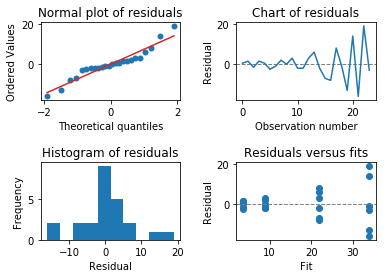

In [10]:
anova(weeds, xlabel='herbicide', ylabel='weed #', lsd=True)

On visual inspection, herbicides A and B are significantly different, while C and D are not. However, if we trust the LSD value this is not true. What happened is that the pooling of variances has resulted in biaised t-tests. The test of difference between A and B is based on an overestimated variance while the test between C and D is based on an underestimated variance. **When variances are wrongly pooled, confidence intervals for individual means are meaningless due to wrong standard error of differences**.

With data such as these, it is safer to present individual standard errors of the mean and perform t-tests based on data from the two compared samples only.

A quick check of homogeneity of variance is to examine the chart of residuals versus fits. We can see the vertical spread of points is not homogeneous as it is higher on the right side of the graph than on the left side.

### 1.4 Additivity

Validity of the analysis is based on the assumption that the yields are made of components which are added together. For example, when carrying out an independent samples t-test you assume the two population variances are equal. This is a reasonable assumption, if effects are additive. Suppose one treatment (A) is expected to give higher yields than the other (B). Treatment A should have the effect of raising the yield by an equal amount on all the plots to which it is applied, over and above the yield which would have been obtained from B. If the plots receiving each treatment are selected at random, the additivity assumption predicts that the variation in the yields of the two sets of plots should be the same.

For the completely randomised design, each yield value is assumed to be made of an overall mean value plus a treatment effect plus a random component. This means that the replicate values for a given treatment differ only in their random components. This means that the replicate values for a given treatment differ only in their random components. These random components are estimated by the residuals, which are the differences between the yields and the corresponding treatment means.

For the randomised block design each yield is assumed to be made up of an overall mean plus a block effect plus a treatment effect plus a random component. For example, in a low-fertility block, the yields for treatments A and B may be 20 and 30. In a high-fertility block, the yield gap is still expected to be 10, so the yield of A and B are 40 and 50. **The treatment and block effects are additive**. Treatment B is expected to outyield  A by 10 units in all conditions, and the high fertility has raised both yields by 20.

If treatment B is expected to outyield A by a constant percentage in all conditions, **the block and treatment effects are multiplicative**. In the low-fertility block the yield of B is 50% greater than the yield of A. If the effects are multiplicative, the high fertility doubles the yield, A is raised from 20 to 40 and B is raised from 30 to 60.

The effects of non-additivity are similar to the effects of non-homogeneity of variance on the ANOVA. Often the non-homogeneity of variance is due to the non-additivity so a transformation that corrects for one corrects for the other. For example, insecticide treatments are likely to be non-additive. If one insecticide halves the number of insects, a plot that had 20 insects before spraying should have 10 afterwards. A plot that had 1000 insects should have 500 after spraying.

Before analysing multiplicative data you should take logarithms. The logarithms conform to the additive model. Also, the variances of the transformed data are more likely to be homogeneous, so the analysis of variance of the logarithms is likely to be valid. Note that you cannot take the logarithm of zero or a negative number. If the data are counts and contain zeros, add one (or a number between zero and one) to every count before taking logarithms.

## 2. Transformations

If the data do not conform to the assumptions which validate ANOVA and t-test, it may be possible to transform the data to a new scale which conforms to the assumptions. In this case, ANOVA and t-tests carried out on the transformed data will be valid. Presentation of the results should include the untransformed and transformed treatment means, and the standard error of the difference for comparing the transformed means.

Transformations should be avoided unless they are obviously necessary to avoid biaised tests of significance. Given the speed of computer analysis, it is better to compare the results with and without transformations. If alternate analyses lead to the same conclusions, it is best to present the results based on the untransformed data. The transformation chosen should be the one that most closely satisfies the ANOVA assumptions, and this may not be the one which gives the results you are looking for.

Some types of data should be routinely transformed. For example, data on insect counts should be transformed by taking logarithms of the counts or the counts plus one. Data on proportion often need to be transformed using an arcsin or angular transformation. Data on area may need a square root transformation.

**Before making a decision to use transformations you should always carry out an analysis of the residuals in order to check the assumptions of ANOVA.**

The checks most used are a histogram of the residuals, a normal plot of the residuals and graph of the residuals versus the fitted values. In regression models plots of the residuals versus the X values are also useful.

If the homogeneity of variance assumption is true, a scatter graph of the residuals against will have a random distribution. Any tendency of the variation in the residuals to increase or decrease with the fitted values is evidence of non-homogeneity of variance associated with non-additivity and/or non-normality. This scatter graph will also identify **outliers**. These are extreme observations which have a large influence on the outcome of the analysis. Outliers should be checked to find out if they are due to recording errors. If they are, they should be removed from the analysis or taken as missing values.

From the graphs shown above, we can see the histogram of residuals shows a large number of small residuals and a small number of very large residuals. The graph of residuals against fitted values shows that, as the fitted values increase, so the variation in the residuals. This suggests a log of square root transformation is required. The residuals are set along vertical lines because in one-way ANOVA the fitted values are the treatment means.

The three most common transformations are the **log**, **square root** and **arcsin**.

### 2.1 Logarithmic transformation

The logarithmic transformation is often required for counts such as the number of diseased plants per plot and number of insects per plant. These data are counts that frequently cover a wide range from single-digit numbers to numbers in hundreds or thousands. If the data contain zeros, add one to each number before taking logs. Below is shown the ANOVA for the natural logarithm-transformed data (focus on the graphs for assumption-checking). The normal plot is straighter but the histogram of residuals is now skewed. The graph showing residuals versus fitted values indicates the homogeneity of variances may be valid, now. Note that a transformation which corrects one assumption may introduce a new violation.

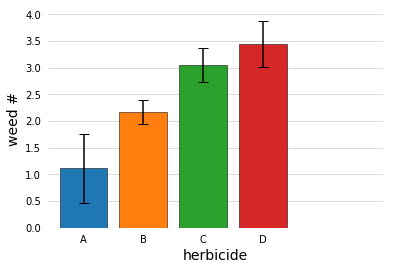

Analysis of variance
Source            df    Sum sq   Mean sq   F-value   p-value
Treatments         3     19.33      6.44    34.216   0.00000
Residuals         20      3.77      0.19
Total             23     23.09

Level         N      Mean     StDev
A             6     1.114     0.641
B             6     2.175     0.228
C             6     3.049     0.323
D             6     3.451     0.431

Coefficient of variation : 17.73%

LSD : 0.523


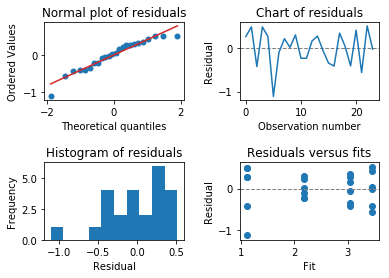

In [13]:
weeds_log = np.log(weeds)
anova(weeds_log, xlabel='herbicide', ylabel='weed #', lsd=True)

### 2.2 The square-root transformation

Data needing square root transformation are typically number of events per unit of time or space when the event is considered rare, for example number of insects caught in a trap. Some researcher recommend the square root transformation for leaf area because it is measured in squared units. Small increases in length when the leaf is small are associated with small increases in area. When the leaf is large, the increases in area are bigger for a given increase in length. This transformation is also recommended for percentage data in the range 0-30% or 70-100%. The figures below show that residuals are likely to be normally distributed, but variances are not homogeneous.

Since violation of homogeneity of variances is more serious than violation of normality, a logarithmic transformation would be better than a square root transformation.

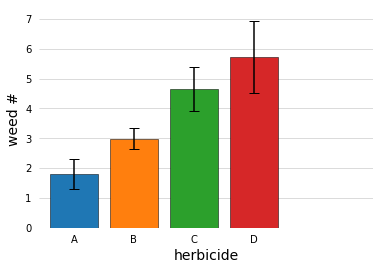

Analysis of variance
Source            df    Sum sq   Mean sq   F-value   p-value
Treatments         3     54.13     18.04    30.289   0.00000
Residuals         20     11.91      0.60
Total             23     66.05

Level         N      Mean     StDev
A             6     1.814     0.500
B             6     2.983     0.345
C             6     4.643     0.732
D             6     5.724     1.216

Coefficient of variation : 20.36%

LSD : 0.930


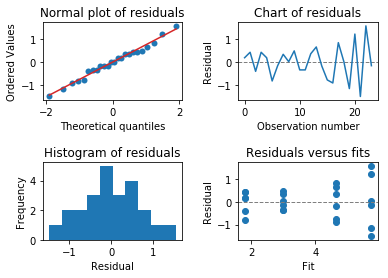

In [14]:
weeds_sqrt = np.sqrt(weeds)
anova(weeds_sqrt, xlabel='herbicide', ylabel='weed #', lsd=True)

### 2.3 The arcsin transformation

This transformation, also called the *angular* transformation, is suitable for percentages based on counts. Each percentage is divided by 100 to convert it to a proportion. The angle whose sine is the square root of the proportion is used as the transformed value. Thus each percentage value is converted to an angle between 0 and 90 degrees.

If percentages are based on ratios of measurements, they arise from continuous data so the angular transformation should not be used.

### 2.4 An alternative to transformation

Non-parametric tests can be an alternative to transformations if the assumptions are not valid. Another alternative is to consider generalised linear models. These are suitable if the residuals follow one of a number of distributions other than the normal distribution.